# Generating images with MX-Font model from a reference style
In this example we'll generate images with trained MX-Font model from a reference style.
If you want to generate multiple styles, please check using `eval.py` instead of using this example file (because it is much simpler to load the referece styles).

### 1. Loading packages
* First, load the packages used in this code.
* All of the packages are avilable in `pip`.

In [1]:
import json
from pathlib import Path
from PIL import Image

import torch
from sconf import Config
from torchvision import transforms

* These modules are defined in this repository.

In [2]:
import models
from datasets import read_font, render
from utils import save_tensor_to_image

### 2. Build model
* Build and load the trained model.
* `weight_path` : 
    * The location of the trained model weight.

In [3]:
########################################################
weight_path = "generator.pth"  # path to weight to infer
########################################################

cfg = Config("cfgs/eval.yaml", default="cfgs/defaults.yaml")
transform = transforms.Compose(
    [transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)
decomposition = json.load(open("data/chn_decomposition.json"))

g_kwargs = cfg.get('g_args', {})
gen = models.Generator(1, cfg.C, 1, **g_kwargs).cuda().eval()
weight = torch.load(weight_path)
if "generator_ema" in weight:
    weight = weight["generator_ema"]
gen.load_state_dict(weight)

<All keys matched successfully>

### 3. Load reference images.
* `ref_path`: 
    * The path of reference font or images.
    * If you are using a ttf file, set this to the location of the ttf file.
    * If you want to use rendered images, set this to the path to the directory which contains the reference images.
* `extension`:
    * If you are using image files, set this to their extension(png, jpg, etc..). 
    * This will be ignored if `use_ttf` is True.
* `batch_size`:
    * The number of images inferred at once.

In [4]:
########################################################
ref_path = "data/images/test/ZCOOLKuaiLe-Regular"  # Path to the reference images
extension = "png"  # Extension of the reference images
batch_size = 3  # The batch size
########################################################

ref_paths = Path(ref_path).glob(f"*.{extension}")
ref_imgs = torch.stack([transform(Image.open(str(p))) for p in ref_paths]).cuda()
ref_batches = torch.split(ref_imgs, batch_size)

### 4. Extract style factors from reference images.

In [5]:
style_facts = {}

for batch in ref_batches:
    style_fact = gen.factorize(gen.encode(batch), 0)
    for k in style_fact:
        style_facts.setdefault(k, []).append(style_fact[k])
        
style_facts = {k: torch.cat(v).mean(0, keepdim=True) for k, v in style_facts.items()}

### 5. Generate the images.
* `gen_chars`: The characters to generate.
* `save_dir`: Path to save the generated images.
* `source_path`: Path to the font file used as the source font.

In [7]:
########################################################
gen_chars = "意味岸"  # Characters to generate
save_dir = Path("./results")  # Directory where you want to save generated images
source_path = "data/chn_source.ttf"  # Path to the font file to render the source images
########################################################

save_dir.mkdir(parents=True, exist_ok=True)

source_font = read_font(source_path)
for char in gen_chars:
    source_img = transform(render(source_font, char)).unsqueeze(0).cuda()
    char_facts = gen.factorize(gen.encode(source_img), 1)
    
    gen_feats = gen.defactorize([style_facts, char_facts])
    out = gen.decode(gen_feats).detach().cpu()[0]

    path = save_dir / f"{char}.png"
    save_tensor_to_image(out, path)

load single font file: data/ttfs/train/MaShanZheng-Regular.ttf
load single font file: data/ttfs/train/ZCOOLKuaiLe-Regular.ttf
Generating sample...


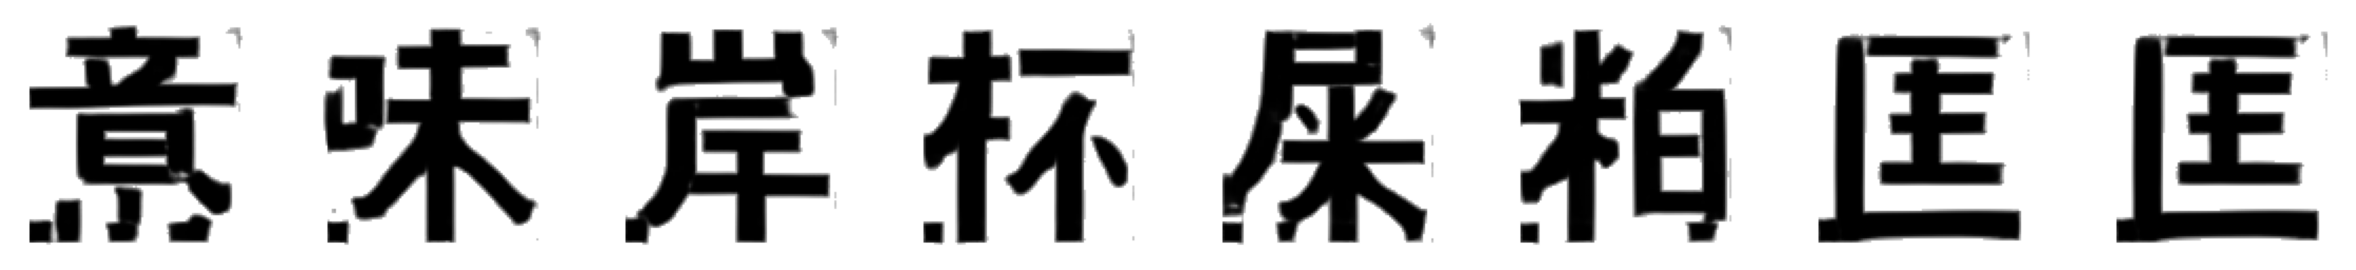

In [2]:
from mxfontpp import MXFontpp
from sconf import Config
from font2data.FontData import FontData
from font2data.utils import show_images

cfg = Config("cfgs/eval.yaml", default="cfgs/defaults.yaml")
mxfontpp = MXFontpp(cfg, weight_path="results/340000.pth")

src_font = FontData("data/ttfs/train/MaShanZheng-Regular.ttf", font_size=128)
ref_font = FontData("data/ttfs/train/ZCOOLKuaiLe-Regular.ttf", font_size=128)

x_src = mxfontpp.preprocess(src_font.char2img("意味岸杯屎粕匡匡")).to('cuda') 
x_ref = mxfontpp.preprocess(ref_font.char2img("意味岸劣杯屎旺火火")).to('cuda') 
# # Tensor of source Images
# x_src = torch.randn(10,1,img_size,img_size).to('cuda') 
# # Tensor of refrence Images
# x_ref = torch.randn(10,1,img_size,img_size).to('cuda')
out = mxfontpp.gen_sample(x_src, x_ref, return_pil_image=False)
out = [o.squeeze(0) for o in out]

show_images(out,nrows=1, show=False)